In [2]:
from pathlib import Path
import time
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

exec(open("functions.py").read())

In [3]:
# set basic parameters and subdirectory
part_n = 500
e_part_r = 0.8
e_mean = 4
excess_i = 0#10
ei_std_s = [4, 4]
waiting_time = 300
interval_len = waiting_time + 1280#2560
freq = 0

In [48]:
# generate and save parameters for simulation
seed = round(time.time())
print(seed)
key = jax.random.PRNGKey(seed)

sub_part_r_s = jnp.array([e_part_r, 1 - e_part_r])
sub_part_n_s = sub_part_n_s_fct(part_n, sub_part_r_s)
unscaled_mean = ei_mean_balancer(sub_part_r_s, e_mean, excess_i)
unscaled_std = jnp.tile(jnp.array([ei_std_s]), (2, 1))
connectivity_n = 1
in_r = 1.
rewiring_prob = 1.
[connectivity_s, key] = row_sum_removing_sparsifier(
  connectivity_s_generator(sub_part_n_s, unscaled_mean, unscaled_std, jnp.array([[0]]),
                           connectivity_n,
                           key),
  sub_part_n_s, unscaled_mean, in_r, rewiring_prob)

sub_part_n_s_ext_gen = jnp.array([part_n])
ext_part_n = 1
ext_sub_part_r_s = jnp.array([1.])
ext_sub_part_n_s = sub_part_n_s_fct(ext_part_n, ext_sub_part_r_s)
unscaled_ext_mean = jnp.array([[0.]])
unscaled_ext_std = jnp.array([[1.]])
# ext_connectivity_n = 6

angN=6
angs=jnp.arange(6)/5*jnp.pi#/2
inter_instance_correlation = jnp.cos(angs-jnp.expand_dims(angs,1))

instN=10
ext_saver=[0 for idx in range(instN)]
for idx in range(instN):
  seedext = round(time.time()*idx)
  keyext = jax.random.PRNGKey(seedext)
  ext_saver[idx] = ext_connectivity_s_generator(
    sub_part_n_s_ext_gen, ext_sub_part_n_s,
    unscaled_ext_mean, unscaled_ext_std, inter_instance_correlation,
    angN,#ext_connectivity_n, 
    keyext)[0]
# ext_mean=0#.5
# ext_connectivity_s = ext_connectivity_s + ext_mean

phase_n = 1
[phase_s, key] = phase_s_generator(ext_part_n, phase_n, key)
phase_s = 0 * phase_s # since freq = 0

amp_s = jnp.expand_dims(jnp.array([0, 2.4]),
                        # or (wave_n, ext_part_n) array so different ext parts have different amps
                        1)
freq_s = jnp.full(amp_s.shape, freq)
wave_s = jnp.concatenate([amp_s, freq_s], axis = 1)
wave_n = wave_s.shape[0]

init_condition_n = 1
ext_condition_n = ext_connectivity_n * phase_n
init_condition_n_free = init_condition_n * ext_condition_n
[init_condition_s, key] = init_condition_s_generator(part_n, 
                                                           jnp.full((part_n, ), 0), jnp.identity(part_n), 
                                                           init_condition_n_free, key)

label_s = jnp.array([1])
label_s_free = jnp.array([0])
time_interval_s = jnp.array([[0, interval_len]])
window_len_s = jnp.array([10, 40, 160, 640]) # used length = 1000
labeled_time_interval_s = [time_interval_s, label_s]
labeled_time_interval_s_free = [time_interval_s, label_s_free]

resolution = 24

condition_n_s = jnp.array([connectivity_n, wave_n, ext_connectivity_n, phase_n,
                             init_condition_n])
condition_n_s_free = jnp.array([connectivity_n, 1, 1, 1,
                                  init_condition_n_free])

1706910862


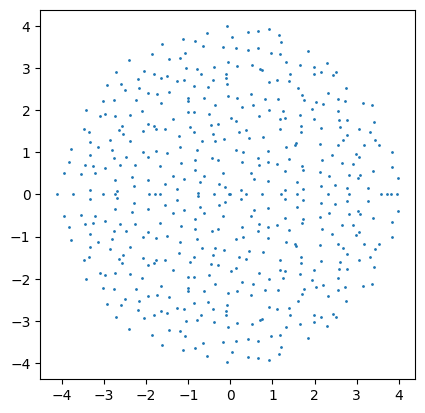

In [49]:
# plot spectra
[fig, subfig_s] = plt.subplots(1, int(connectivity_n), squeeze = False)
for connectivity_idx in range(connectivity_n):
  temp_spectrum = jnp.linalg.eig(connectivity_s[connectivity_idx])[0]
  subfig_s[0, connectivity_idx].plot(jnp.real(temp_spectrum), jnp.imag(temp_spectrum),
                                  linestyle="", marker=".", markersize = 2)
  subfig_s[0, connectivity_idx].set_aspect('equal')

In [50]:
popmeans=[0 for idx in range(instN)]

joined_time_interval = jnp.array([0, interval_len])
temp_traj_holder = traj_initializer(init_condition_s[0], joined_time_interval, resolution)
for idx in range(instN):
  subpopmeans=[0 for idx in range(angN)]
  for subidx in range(angN):
    temp_traj = temp_traj_holder.at[..., 0].set(init_condition_s[0])
    temp_traj = rk4_ode_solver(
      lambda position:
      almlin_velocity_fct(connectivity_s[0], position),
      lambda time:
      sin_ext_input_fct(
        wave_s[1],#jnp.array([0,0]), 
        ext_saver[idx][subidx], phase_s[0],
        labeled_time_interval_s, time),
      temp_traj,
      joined_time_interval[0], resolution)
    subpopmeans[subidx]=jnp.mean(temp_traj)
  popmeans[idx]=subpopmeans

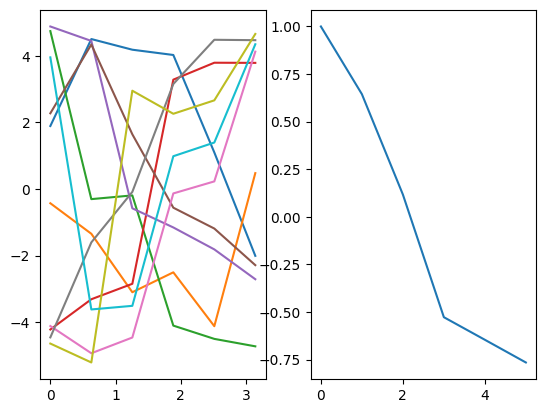

In [51]:
popmeans=jnp.array(popmeans)
[fig, subfig_s] = plt.subplots(1, 2, squeeze = False)
subfig_s[0,0].plot(angs, popmeans.T);
subfig_s[0,1].plot([jnp.corrcoef(popmeans[:,0],popmeans[:,idx])[0,1] for idx in range(angN)])